**EXERCISE 1**

Data Loaded: 18 rows total.
   > Zero rates (<1y): 4
   > Par rates (>=1y): 14
Starting calibration...

CALIBRATED NSS PARAMETERS
beta0 (Level)   : 0.02546131
beta1 (Slope)   : -0.00297975
beta2 (Curve1)  : 0.04508311
beta3 (Curve2)  : -0.02871212
tau1 (Decay1)   : 0.66718078
tau2 (Decay2)   : 1.70656572


--- Interpolated Par Rates & Zero-Coupon Bond Values ---
Year  | Par Rate     | Discount Factor | Zero Rate (cc) 
-------------------------------------------------------
1     | 0.031958      | 0.969032         | 0.031458
2     | 0.028993      | 0.944520         | 0.028539
3     | 0.026084      | 0.925934         | 0.025651
4     | 0.024458      | 0.908337         | 0.024035
5     | 0.023719      | 0.889994         | 0.023308
6     | 0.023463      | 0.870751         | 0.023067
7     | 0.023443      | 0.850912         | 0.023064
8     | 0.023529      | 0.830817         | 0.023168
9     | 0.023655      | 0.810732         | 0.023313
10    | 0.023790      | 0.790837         | 0.023466
11

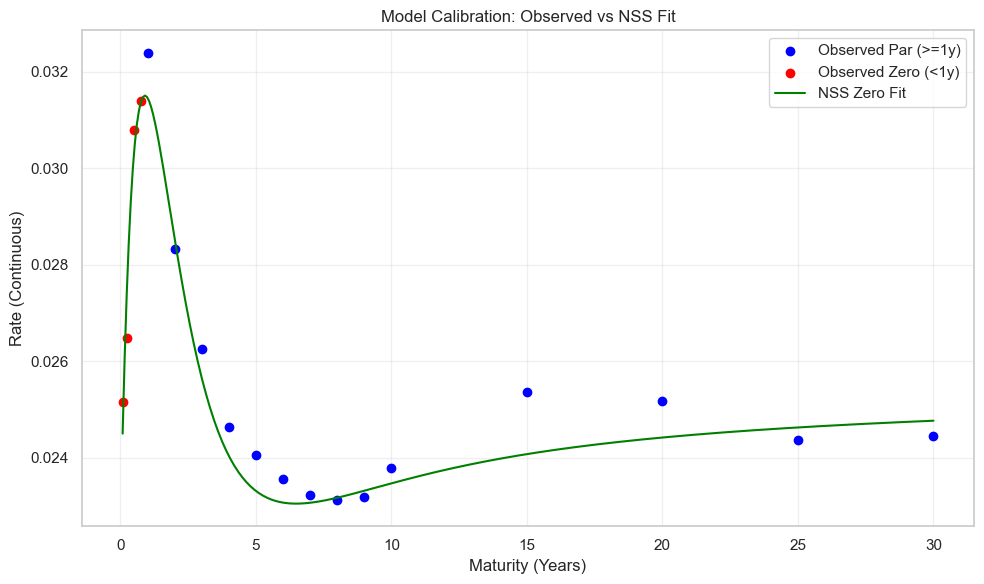

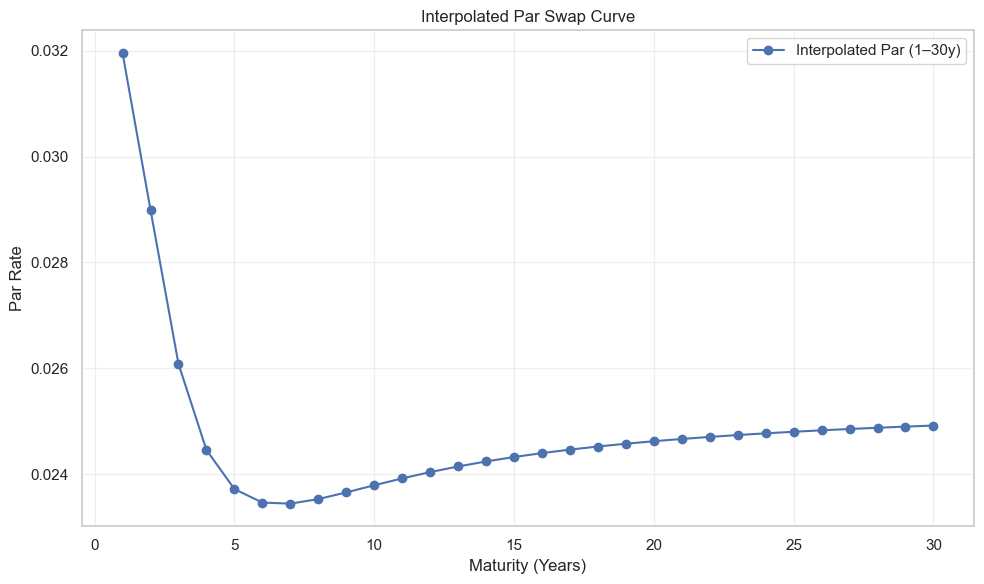

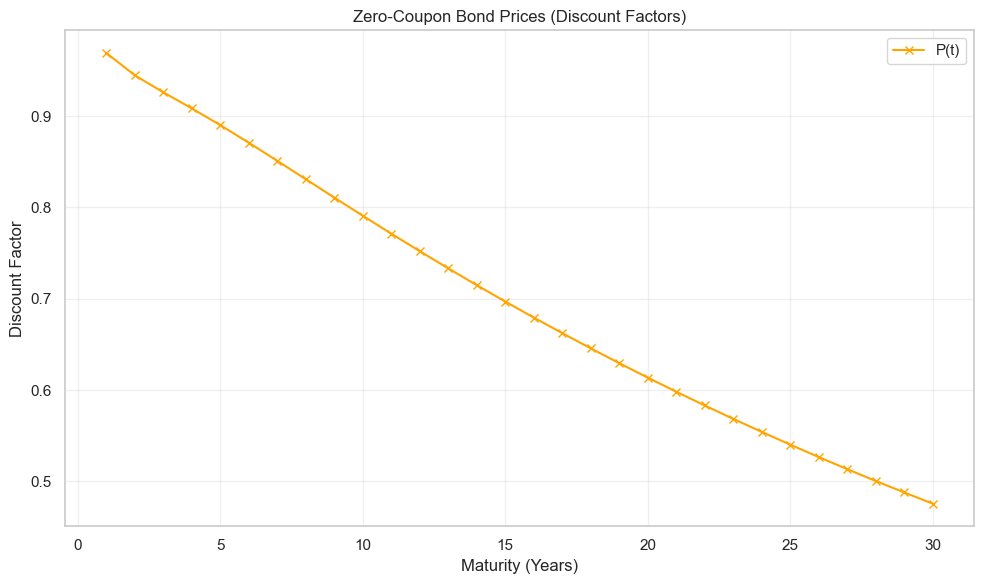

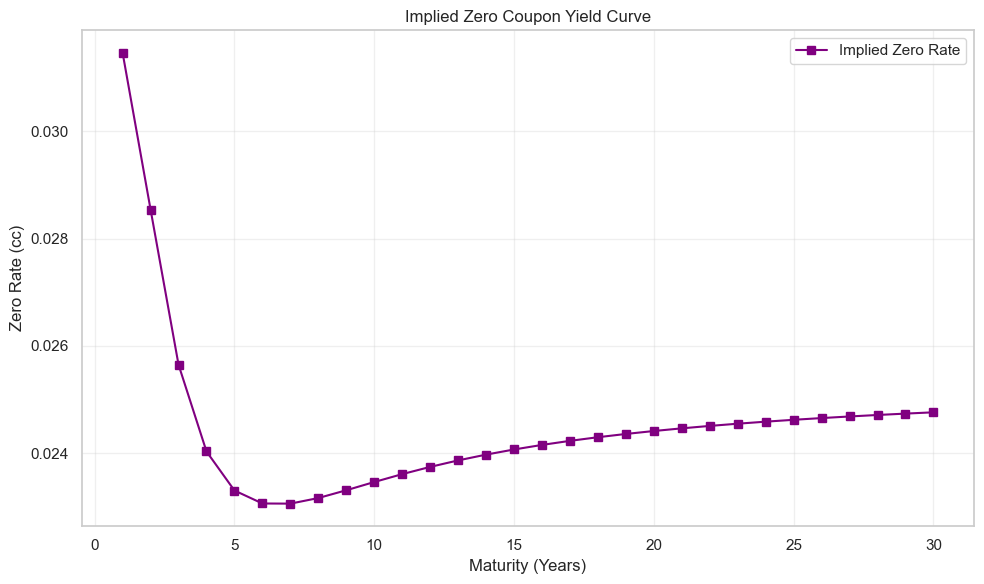

In [12]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import least_squares

# --- Configuration ---
# Update these paths if your file name or sheet name changes
FILE_PATH = Path("market_data2.xlsx")
SHEET_NAME = "swap curve"

# --- Part 1: Data Parsing & Loading ---

def _parse_tenor_to_years(x):
    """
    Helper function to convert financial tenors (strings) into numeric years.
    Examples: '6M' -> 0.5, '10Y' -> 10.0.
    """
    if pd.isna(x):
        return np.nan
    
    # Normalize string: remove spaces, convert to uppercase
    s = str(x).strip().upper().replace(" ", "")
    
    # regex: Look for a number followed strictly by 'M' (Months) or 'Y' (Years)
    match = re.fullmatch(r'(\d+(?:\.\d+)?)([MY])', s)
    if match:
        val = float(match.group(1))
        unit = match.group(2)
        return val / 12.0 if unit == "M" else val

    # If the format isn't recognized, return NaN
    return np.nan

def load_and_clean_curve(file_path: Path, sheet_preferred: str):
    """
    Loads raw market data from Excel, parses maturities, and separates 
    short-term zero rates from long-term par swap rates.
    """
    xls = pd.ExcelFile(file_path)
    
    # Try to find the preferred sheet; otherwise default to the first one
    sheet = next((s for s in xls.sheet_names if s.strip().lower() == sheet_preferred.strip().lower()),
                 xls.sheet_names[0])

    # Read the first two columns as strings to avoid pandas auto-formatting errors
    raw = pd.read_excel(file_path, sheet_name=sheet, header=None, usecols=[0, 1], dtype=str)
    raw.columns = ["maturity_raw", "rate_raw"]

    # Convert tenor strings (e.g., "6M") to numeric years
    raw["maturity"] = raw["maturity_raw"].apply(_parse_tenor_to_years)

    # Clean up the rates: remove %, replace commas with dots, and convert to float
    cleaned_rates = (raw["rate_raw"]
                     .astype(str)
                     .str.replace("%", "", regex=False)
                     .str.replace(",", ".", regex=False))
    raw["rate"] = pd.to_numeric(cleaned_rates, errors="coerce")

    # Filter out bad rows (NaNs) and ensure maturities are positive
    df = raw.dropna(subset=["maturity", "rate"]).copy()
    df = df[df["maturity"] > 0]

    # Standardization: If rates look like integers (e.g., 5.0 for 5%), convert to decimals (0.05)
    if df["rate"].median() > 1.0:
        df["rate"] = df["rate"] / 100.0

    # Logic split: 
    # Maturities < 1 year are treated as zero-coupon rates (e.g., LIBOR/Euribor)
    # Maturities >= 1 year are treated as par swap rates
    short_term = df[df["maturity"] < 1].copy()
    long_term  = df[df["maturity"] >= 1].copy()

    print(f"Data Loaded: {len(df)} rows total.")
    print(f"   > Zero rates (<1y): {len(short_term)}")
    print(f"   > Par rates (>=1y): {len(long_term)}")
    
    return short_term, long_term

# --- Part 2: Nelson-Siegel-Svensson (NSS) Model ---

def nss_zero_rate(t, beta0, beta1, beta2, beta3, tau1, tau2):
    """
    Calculates the NSS zero rate (continuous compounding) for time t.
    """
    t = np.asarray(t, dtype=float)
    
    # Helper function for the exponential decay terms
    def f(u):
        # Handle division by zero edge case
        return np.where(u == 0.0, 1.0, (1.0 - np.exp(-u)) / u)
    
    u1 = t / tau1
    u2 = t / tau2
    
    # The four components of the NSS formula
    term1 = beta0
    term2 = beta1 * f(u1)
    term3 = beta2 * (f(u1) - np.exp(-u1))
    term4 = beta3 * (f(u2) - np.exp(-u2))
    
    return term1 + term2 + term3 + term4

def theoretical_par_rate(n, nss_params):
    """
    Calculates the theoretical Par Swap Rate for a maturity 'n' using the NSS parameters.
    Assumes annual coupons (alpha=1).
    """
    # Create a grid of payment dates (1 year, 2 years... up to n)
    t_grid = np.arange(1, int(n) + 1, dtype=float)
    
    # Get zero rates and discount factors from the model
    z_rates = nss_zero_rate(t_grid, *nss_params)
    discount_factors = np.exp(-z_rates * t_grid)
    
    # Swap Rate Formula: (1 - P_final) / Sum(P_i)
    annuity = discount_factors.sum()
    return (1.0 - discount_factors[-1]) / annuity

# --- Part 3: Calibration Engine ---

def calibrate_nss_model(short_data: pd.DataFrame, long_data: pd.DataFrame):
    """
    Fits the NSS parameters to the market data using non-linear least squares.
    """
    # Prepare data arrays
    obs_zero_t = short_data["maturity"].values
    obs_zero_y = short_data["rate"].values
    obs_par_n  = long_data["maturity"].values
    obs_par_S  = long_data["rate"].values

    # Strategy: Guess the "Level" (beta0) based on the long-end data to help convergence
    if len(obs_par_S) > 0:
        beta0_guess = max(float(np.nanmax(obs_par_S)), 0.01)
    elif len(obs_zero_y) > 0:
        beta0_guess = max(float(np.nanmean(obs_zero_y)), 0.01)
    else:
        beta0_guess = 0.02

    # Initial guess vector: [beta0, beta1, beta2, beta3, tau1, tau2]
    initial_guess = np.array([beta0_guess, -0.02, 0.02, 0.01, 1.0, 3.0], dtype=float)
    
    # Bounds to keep parameters in a sane range
    # Lower Bounds / Upper Bounds
    lower_bounds = np.array([-0.05, -2.0, -2.0, -2.0, 1e-4, 1e-4], dtype=float)
    upper_bounds = np.array([ 0.20,  2.0,  2.0,  2.0, 10.0, 10.0], dtype=float)

    def residuals(theta):
        res = []
        
        # 1. Error on short-end zero rates
        if len(obs_zero_t) > 0:
            y_model = nss_zero_rate(obs_zero_t, *theta)
            res.append(y_model - obs_zero_y)
            
        # 2. Error on long-end par swap rates
        if len(obs_par_n) > 0:
            # We round maturity to nearest integer for annual coupon calculation
            n_int = np.asarray(np.round(obs_par_n).astype(int))
            S_model = np.array([theoretical_par_rate(n, theta) for n in n_int])
            res.append(S_model - obs_par_S)

        return np.concatenate(res) if res else np.array([0.0])

    # Optimize
    print("Starting calibration...")
    solution = least_squares(residuals, x0=initial_guess, bounds=(lower_bounds, upper_bounds), 
                             method="trf", max_nfev=8000)
    
    return solution.x

# --- Part 4: Bootstrapping ---

def bootstrap_discount_factors(par_rates, year_grid):
    """
    Standard bootstrapping method to extract Discount Factors from Par Rates.
    Assumes annual frequency on an integer grid.
    """
    prices = {} # Dictionary to store P(t)
    
    for n, S in zip(year_grid.astype(int), par_rates):
        # Sum of previous discount factors (annuity part)
        sum_prev = sum(prices[i] for i in range(1, n))
        
        # Solve for current discount factor P(n)
        Pn = (1.0 - S * sum_prev) / (1.0 + S)
        prices[n] = Pn
        
    return np.array([prices[int(n)] for n in year_grid])

# --- Part 5: Main Execution Logic ---

if not FILE_PATH.exists():
    raise FileNotFoundError(f"File not found: {FILE_PATH.resolve()}")

# 1. Load Data
short_term, long_term = load_and_clean_curve(FILE_PATH, SHEET_NAME)

# 2. Run Calibration
nss_params = calibrate_nss_model(short_term, long_term)

# 3. Print Calibration Results
param_names = ["beta0 (Level)", "beta1 (Slope)", "beta2 (Curve1)", 
               "beta3 (Curve2)", "tau1 (Decay1)", "tau2 (Decay2)"]

print("\n" + "="*45)
print("CALIBRATED NSS PARAMETERS")
print("="*45)
for name, value in zip(param_names, nss_params):
    print(f"{name:<15} : {value:.8f}")
print("="*45 + "\n")

# 4. Interpolation & Bootstrapping (1 to 30 years)
years_grid = np.arange(1, 31, dtype=float)

# Generate smooth par curve from model
par_interp = np.array([theoretical_par_rate(n, nss_params) for n in years_grid])

# Bootstrap discount factors and implied zero rates
discount_factors = bootstrap_discount_factors(par_interp, years_grid)
zero_rates_cc = -np.log(discount_factors) / years_grid

# 5. Output Table
print("\n--- Interpolated Par Rates & Zero-Coupon Bond Values ---")
print(f"{'Year':<5} | {'Par Rate':<12} | {'Discount Factor':<15} | {'Zero Rate (cc)':<15}")
print("-" * 55)
for t, par, df, z in zip(years_grid, par_interp, discount_factors, zero_rates_cc):
    print(f"{int(t):<5} | {par:.6f}      | {df:.6f}         | {z:.6f}")

# 6. Plotting
# Plot 1: Fit Quality
plt.figure(figsize=(10, 6))
if len(long_term):
    plt.scatter(long_term["maturity"], long_term["rate"], label="Observed Par (>=1y)", color='blue')
if len(short_term):
    plt.scatter(short_term["maturity"], short_term["rate"], label="Observed Zero (<1y)", color='red')
    
mt_grid = np.linspace(0.08, 30.0, 400)
plt.plot(mt_grid, nss_zero_rate(mt_grid, *nss_params), label="NSS Zero Fit", color='green')
plt.xlabel("Maturity (Years)")
plt.ylabel("Rate (Continuous)")
plt.title("Model Calibration: Observed vs NSS Fit")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Plot 2: Interpolated Par Curve
plt.figure(figsize=(10, 6))
plt.plot(years_grid, par_interp, marker='o', label="Interpolated Par (1–30y)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Par Rate")
plt.title("Interpolated Par Swap Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Plot 3: Discount Factors
plt.figure(figsize=(10, 6))
plt.plot(years_grid, discount_factors, marker='x', color='orange', label="P(t)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Discount Factor")
plt.title("Zero-Coupon Bond Prices (Discount Factors)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Plot 4: Implied Zero Curve
plt.figure(figsize=(10, 6))
plt.plot(years_grid, zero_rates_cc, marker='s', color='purple', label="Implied Zero Rate")
plt.xlabel("Maturity (Years)")
plt.ylabel("Zero Rate (cc)")
plt.title("Implied Zero Coupon Yield Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

**EXERCISE 2**

--- Starting CDS Bootstrapping ---
Loading data from sheet: CDS spread_2023
Bootstrapping: Banco Santander...
 Maturity   Spread   Hazard  Survival  Default
      0.5 0.002413 0.004018  0.997993 0.002007
      1.0 0.003028 0.005040  0.995481 0.004519
      2.0 0.004080 0.006777  0.988758 0.011242
      3.0 0.005123 0.008502  0.980387 0.019613
      4.0 0.006190 0.010264  0.970376 0.029624
----------------------------------------


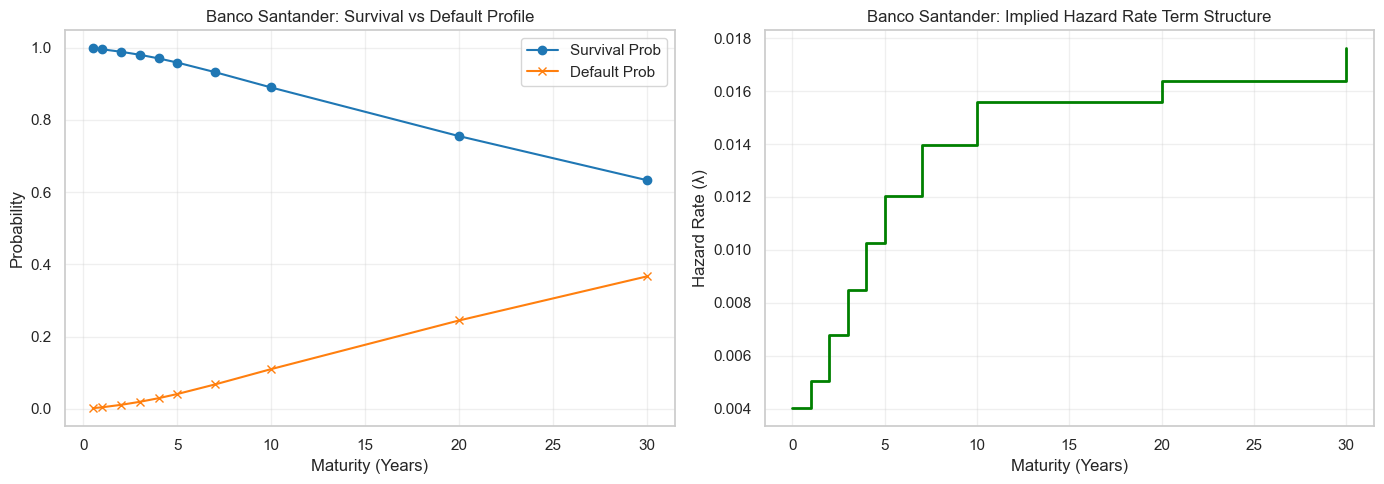

Bootstrapping: Eni...
 Maturity   Spread   Hazard  Survival  Default
      0.5 0.001957 0.003259  0.998372 0.001628
      1.0 0.002684 0.004468  0.996144 0.003856
      2.0 0.003960 0.006578  0.989612 0.010388
      3.0 0.005219 0.008661  0.981079 0.018921
      4.0 0.006531 0.010826  0.970515 0.029485
----------------------------------------


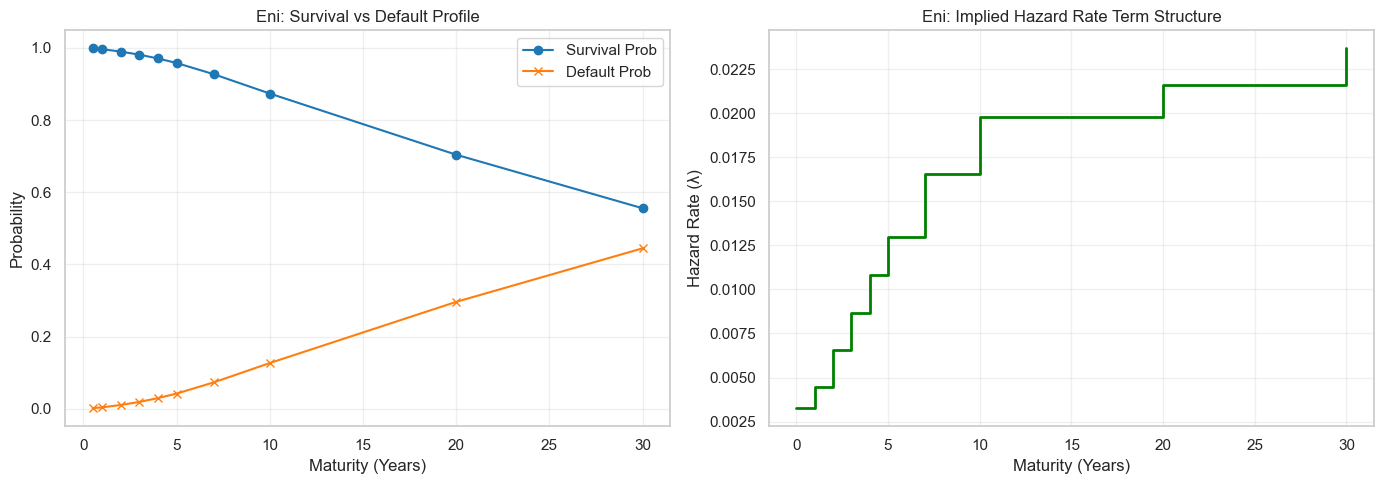

Bootstrapping: Ziggo...
 Maturity   Spread   Hazard  Survival  Default
      0.5 0.009356 0.015533  0.992264 0.007736
      1.0 0.013426 0.022252  0.981285 0.018715
      2.0 0.020892 0.034227  0.948266 0.051734
      3.0 0.029294 0.047669  0.904124 0.095876
      4.0 0.037271 0.060265  0.851246 0.148754
----------------------------------------


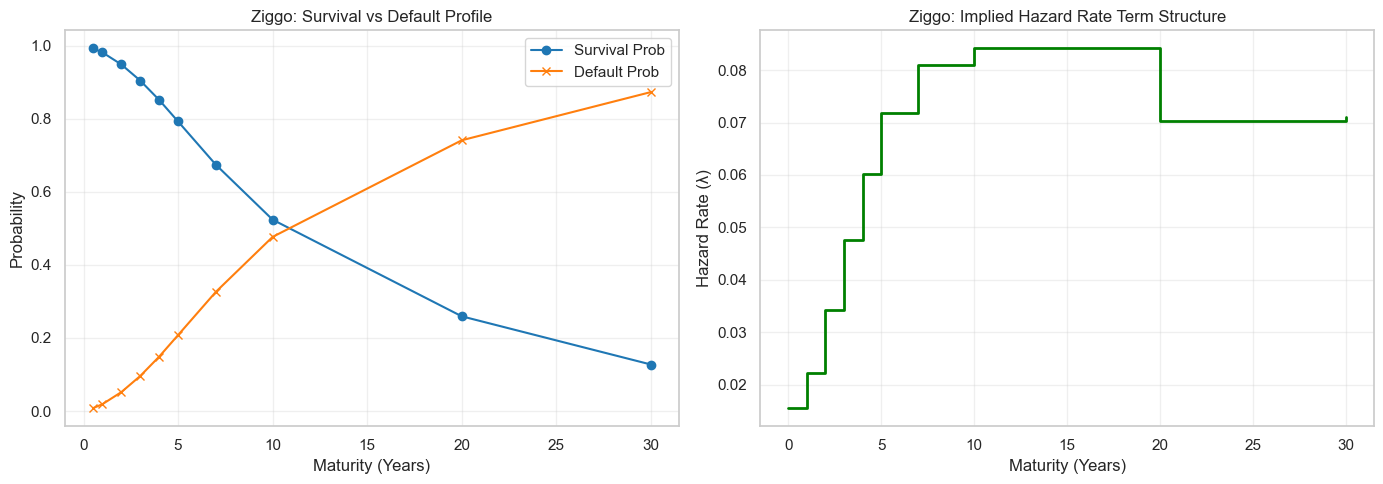

Bootstrapping: Lufthansa...
 Maturity   Spread   Hazard  Survival  Default
      0.5 0.009300 0.015440  0.992310 0.007690
      1.0 0.011994 0.019891  0.982490 0.017510
      2.0 0.013983 0.023038  0.960114 0.039886
      3.0 0.015955 0.026244  0.935244 0.064756
      4.0 0.019829 0.032514  0.905325 0.094675
----------------------------------------


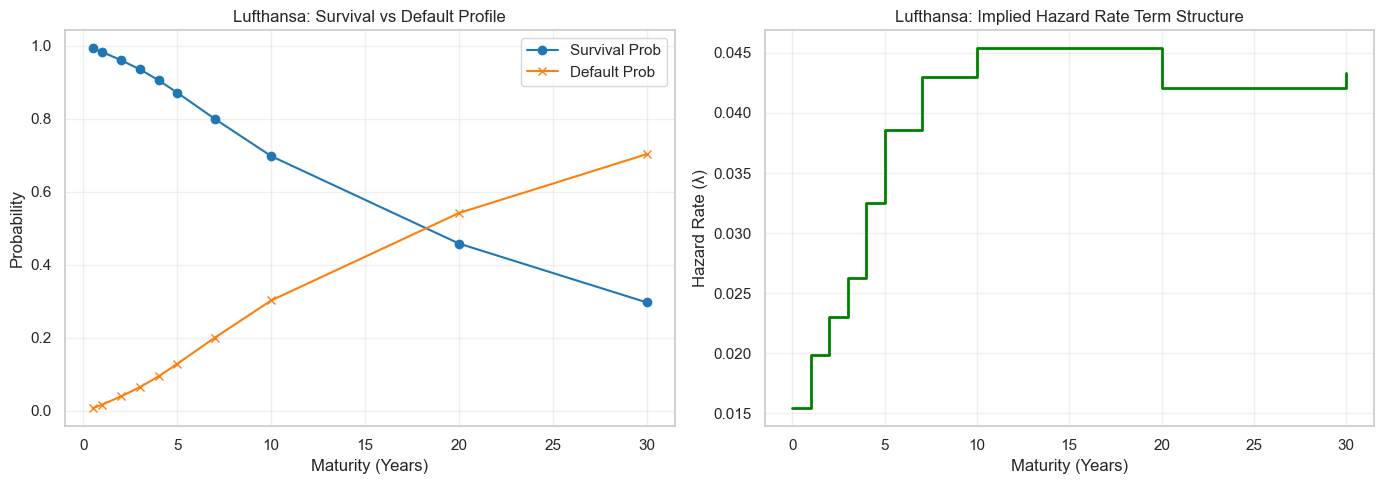

Bootstrapping: Renault...
 Maturity   Spread   Hazard  Survival  Default
      0.5 0.007316 0.012156  0.993940 0.006060
      1.0 0.008313 0.013807  0.987102 0.012898
      2.0 0.015059 0.024789  0.962934 0.037066
      3.0 0.021588 0.035348  0.929491 0.070509
      4.0 0.027344 0.044565  0.888977 0.111023
----------------------------------------


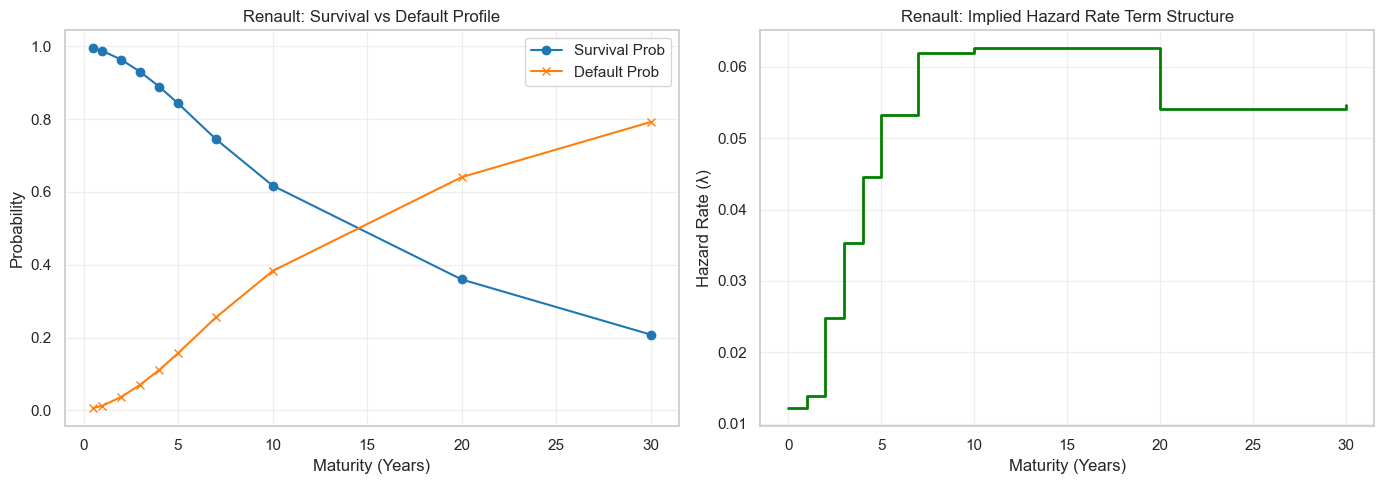

Bootstrapping: Allianz...
 Maturity   Spread   Hazard  Survival  Default
      0.5 0.001484 0.002472  0.998765 0.001235
      1.0 0.002011 0.003349  0.997094 0.002906
      2.0 0.002743 0.004561  0.992556 0.007444
      3.0 0.003467 0.005762  0.986854 0.013146
      4.0 0.004152 0.006896  0.980072 0.019928
----------------------------------------


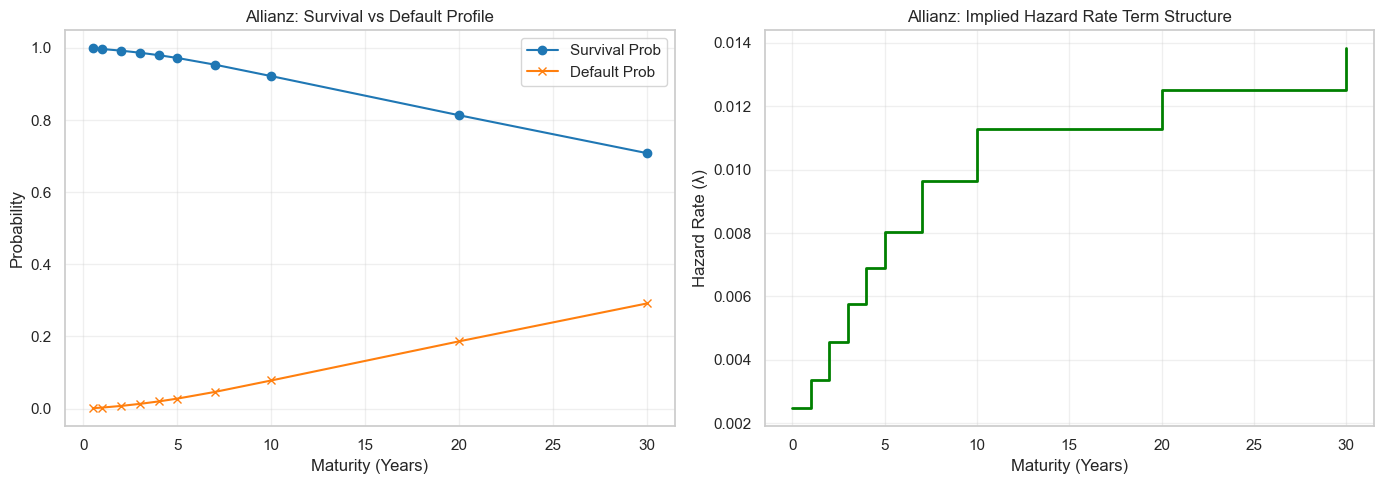

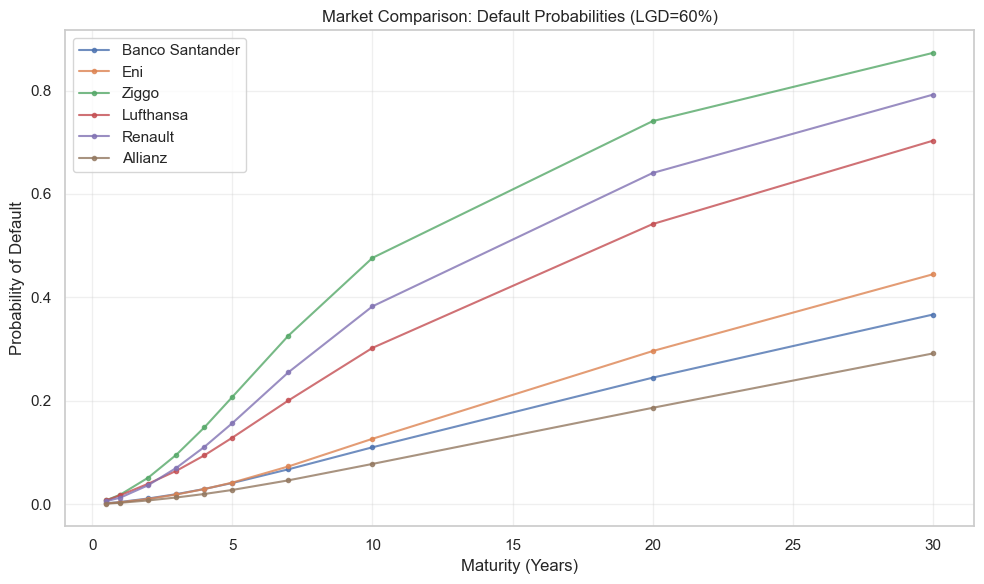

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from pathlib import Path

# ============================================================
# 1. CONFIGURATION & INPUTS
# ============================================================

# File settings
FILE_PATH = Path("market_data2.xlsx")
CDS_SHEET_PREFIX = "CDS spread"  # We'll look for sheets starting with this name

# Market standard assumptions for CDS
RECOVERY_RATE = 0.40
LGD = 1.0 - RECOVERY_RATE  # Loss Given Default

# NSS Parameters (Calibrated from the previous zero-curve exercise)
# These define our risk-free discount factors.
NSS_PARAMS = {
    "beta0": 0.02546,
    "beta1": -0.00298,
    "beta2": 0.04508,
    "beta3": -0.02871,
    "tau1":  0.6672,
    "tau2":  1.7066
}

# ============================================================
# 2. DISCOUNTING LOGIC (NSS MODEL)
# ============================================================

def nss_zero_rate(t, params):
    """
    Computes the continuous zero rate for time t using the Nelson-Siegel-Svensson model.
    """
    # Small epsilon to prevent division by zero errors at t=0
    t = np.maximum(t, 1e-6) 
    
    b0, b1, b2, b3 = params["beta0"], params["beta1"], params["beta2"], params["beta3"]
    t1, t2 = params["tau1"], params["tau2"]
    
    # The standard NSS factors
    term1 = (1 - np.exp(-t/t1)) / (t/t1)
    term2 = term1 - np.exp(-t/t1)
    term3 = (1 - np.exp(-t/t2)) / (t/t2) - np.exp(-t/t2)
    
    return b0 + b1*term1 + b2*term2 + b3*term3

def get_discount_factor(t):
    """
    Returns the risk-free discount factor P(0, t).
    """
    y = nss_zero_rate(t, NSS_PARAMS)
    return np.exp(-y * t)

# ============================================================
# 3. DATA LOADING
# ============================================================

def load_cds_excel(file_path, sheet_prefix):
    """
    Scans the Excel file for a sheet starting with 'CDS spread', 
    cleans the headers, and returns a dictionary of DataFrames (one per entity).
    """
    if not file_path.exists():
        print(f"Warning: '{file_path}' not found. Cannot load data.")
        return {}

    xls = pd.ExcelFile(file_path)
    
    # Find the right sheet (case-insensitive search would be safer, but strict for now)
    target_sheet = next((s for s in xls.sheet_names if s.startswith(sheet_prefix)), None)
    if not target_sheet:
        raise ValueError(f"Could not find a sheet starting with '{sheet_prefix}'")
    
    print(f"Loading data from sheet: {target_sheet}")
    
    # Load raw data; assume no header initially to locate the structure manually
    raw = pd.read_excel(file_path, sheet_name=target_sheet, header=None)
    
    # Row 1 (index 1) usually contains names; Row 2+ (index 2+) contains data
    # Column 1 (index 1) usually contains Maturities
    names = raw.iloc[1, 2:].dropna().values
    maturities = pd.to_numeric(raw.iloc[2:, 1], errors='coerce').values
    
    # Filter out rows where maturity is NaN
    valid_mask = ~np.isnan(maturities)
    maturities = maturities[valid_mask]
    
    cds_dict = {}
    
    for i, name in enumerate(names):
        col_idx = 2 + i
        # Extract spreads and convert to decimals (bps -> decimal)
        # e.g., 100 bps = 0.01
        spreads_bps = pd.to_numeric(raw.iloc[2:, col_idx], errors='coerce').values[valid_mask]
        
        clean_df = pd.DataFrame({
            "Maturity": maturities,
            "Spread": spreads_bps / 10000.0
        }).dropna()
        
        cds_dict[str(name)] = clean_df
        
    return cds_dict

# ============================================================
# 4. BOOTSTRAPPING ENGINE
# ============================================================

def find_implied_hazard(t_start, t_end, spread, survival_prob_start):
    """
    Solves for the constant hazard rate (lambda) between t_start and t_end
    such that PV(Premium Leg) == PV(Protection Leg).
    """
    dt = t_end - t_start
    df_end = get_discount_factor(t_end)
    
    # Objective function: find lambda where Value == 0
    def valuation_diff(lam):
        # Survival Probability at t_end given lambda
        # Q(t_end) = Q(t_start) * exp(-lambda * dt)
        survival_prob_end = survival_prob_start * np.exp(-lam * dt)
        
        # 1. Premium Leg (Money we receive)
        # Approx: Spread * dt * DiscountFactor * SurvivalProbability
        pv_premium = spread * dt * df_end * survival_prob_end
        
        # 2. Protection Leg (Money we pay if default happens)
        # Approx: LGD * DiscountFactor * (Prob of Default in this step)
        prob_default_step = survival_prob_start - survival_prob_end
        pv_protection = LGD * df_end * prob_default_step
        
        return pv_premium - pv_protection

    try:
        # We expect lambda to be between -10% (unlikely) and 500% (distressed)
        # brentq is a robust root-finding method
        implied_lambda = brentq(valuation_diff, -0.1, 5.0, xtol=1e-9)
        return max(implied_lambda, 0.0) # Clamp negative hazards to 0
    except ValueError:
        # Solver failed (e.g., if spread is inconsistent or data is bad)
        return None

def bootstrap_curve(cds_df):
    """
    Iterates through maturities to bootstrap the term structure of hazard rates.
    """
    maturities = cds_df["Maturity"].values
    spreads = cds_df["Spread"].values
    
    results = {
        "Maturity": [], "Spread": [], "Hazard": [], 
        "CumHazard": [], "Survival": [], "Default": []
    }
    
    # Initialize bootstrapping state
    t_prev = 0.0
    surv_prev = 1.0
    cum_hazard = 0.0
    last_valid_lambda = 0.0 # Fallback value
    
    for t, s in zip(maturities, spreads):
        # Calculate the hazard rate for the interval (t_prev, t]
        lam = find_implied_hazard(t_prev, t, s, surv_prev)
        
        # Safety net: if solver fails, assume flat hazard rate from previous step
        if lam is None:
            lam = last_valid_lambda
        else:
            last_valid_lambda = lam
            
        # Update cumulative metrics
        dt = t - t_prev
        cum_hazard += lam * dt
        surv_curr = np.exp(-cum_hazard)
        def_curr = 1.0 - surv_curr
        
        # Store results
        results["Maturity"].append(t)
        results["Spread"].append(s)
        results["Hazard"].append(lam)
        results["CumHazard"].append(cum_hazard)
        results["Survival"].append(surv_curr)
        results["Default"].append(def_curr)
        
        # Move forward
        t_prev = t
        surv_prev = surv_curr
        
    return pd.DataFrame(results)

# ============================================================
# 5. VISUALIZATION
# ============================================================

def plot_entity_analysis(name, df):
    """Generates a detailed 2-panel plot for a single entity."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Panel 1: Probabilities
    ax1.plot(df["Maturity"], df["Survival"], 'o-', color='#1f77b4', label="Survival Prob")
    ax1.plot(df["Maturity"], df["Default"], 'x-', color='#ff7f0e', label="Default Prob")
    ax1.set_title(f"{name}: Survival vs Default Profile")
    ax1.set_xlabel("Maturity (Years)")
    ax1.set_ylabel("Probability")
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Panel 2: Hazard Rate (Step Plot)
    # We add t=0 to make the step plot look rigorous
    t_steps = np.concatenate(([0], df["Maturity"].values))
    h_steps = np.concatenate(([df["Hazard"].values[0]], df["Hazard"].values))
    
    ax2.step(t_steps, h_steps, where='post', color='green', linewidth=2)
    ax2.set_title(f"{name}: Implied Hazard Rate Term Structure")
    ax2.set_xlabel("Maturity (Years)")
    ax2.set_ylabel("Hazard Rate (λ)")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_market_comparison(all_results):
    """Compares Default Probabilities across all loaded entities."""
    plt.figure(figsize=(10, 6))
    
    for name, df in all_results.items():
        plt.plot(df["Maturity"], df["Default"], '.-', label=name, alpha=0.8)
        
    plt.title(f"Market Comparison: Default Probabilities (LGD={LGD:.0%})")
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Probability of Default")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================
# 6. MAIN EXECUTION
# ============================================================

print("--- Starting CDS Bootstrapping ---")

# 1. Load Data
try:
    cds_market_data = load_cds_excel(FILE_PATH, CDS_SHEET_PREFIX)
except Exception as e:
    print(f"Critical Error: {e}")
    cds_market_data = {} # Empty dict to prevent crash in loop

processed_results = {}

# 2. Process each entity found in the Excel file
if not cds_market_data:
    print("No data loaded. Please check the file path.")
else:
    for entity_name, data_df in cds_market_data.items():
        print(f"Bootstrapping: {entity_name}...")
        
        # Run the bootstrap
        result_df = bootstrap_curve(data_df)
        processed_results[entity_name] = result_df
        
        # Display table snippet
        print(result_df[["Maturity", "Spread", "Hazard", "Survival", "Default"]].head().to_string(index=False))
        print("-" * 40)
        
        # specific plot for this entity
        plot_entity_analysis(entity_name, result_df)

    # 3. Market-wide comparison plot
    plot_market_comparison(processed_results)


**EXERCISE 3**

Loaded CDS time series head:
       ENI  Unicredit  Volkswagen  Allianz  Iberdrola
0  73.160    136.564      81.589   34.674     62.952
1  72.332    133.191      80.041   34.757     62.467
2  72.276    135.041      80.954   36.791     62.618
3  72.539    137.895      82.773   39.001     63.712
4  72.019    134.493      79.200   37.389     62.171 

5y default probabilities head:
         ENI  Unicredit  Volkswagen   Allianz  Iberdrola
0  0.012119   0.022504    0.013506  0.005762   0.010437
1  0.011983   0.021954    0.013252  0.005776   0.010357
2  0.011974   0.022255    0.013402  0.006113   0.010382
3  0.012017   0.022720    0.013701  0.006479   0.010562
4  0.011931   0.022166    0.013113  0.006212   0.010308 

Raw Gaussian Copula Correlation Matrix:
                  ENI  Unicredit  Volkswagen   Allianz  Iberdrola
ENI         1.000000   0.741847    0.848969  0.619041   0.044738
Unicredit   0.741847   1.000000    0.843874  0.723123   0.469740
Volkswagen  0.848969   0.843874    1.000000 

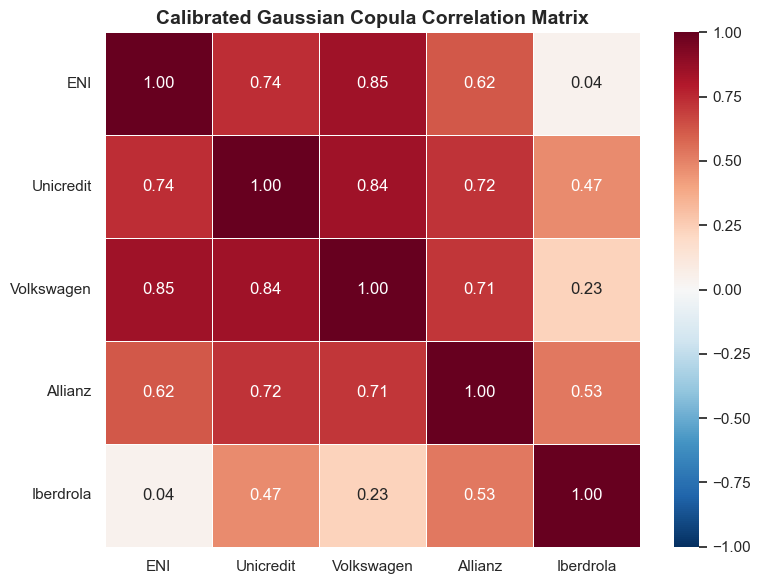

Generating Pairwise Joint Plots...


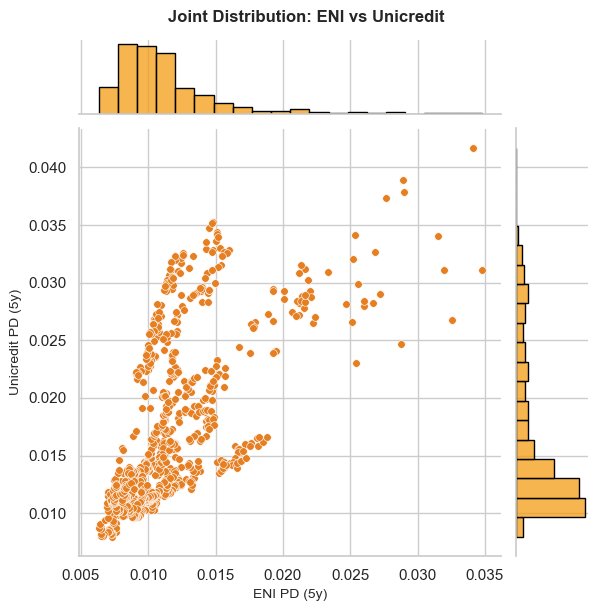

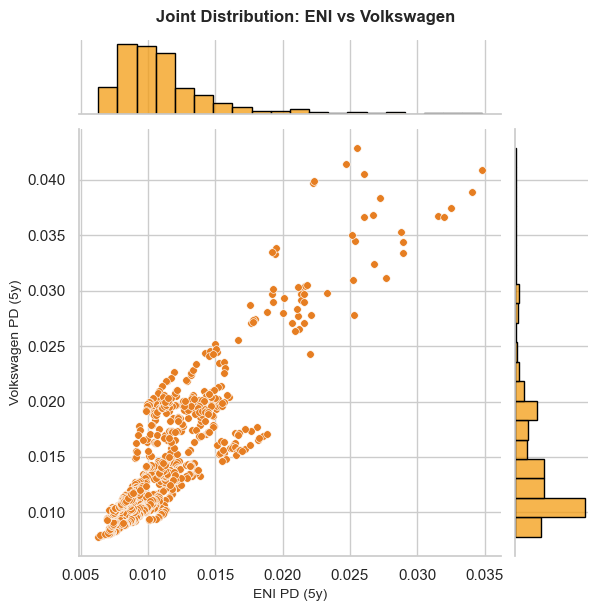

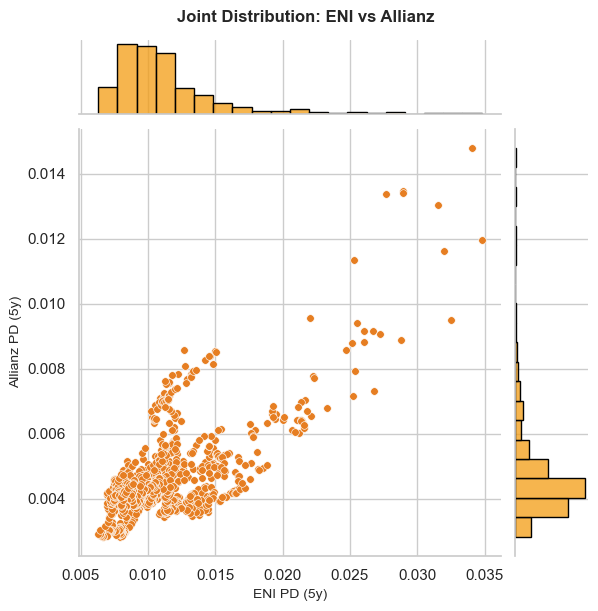

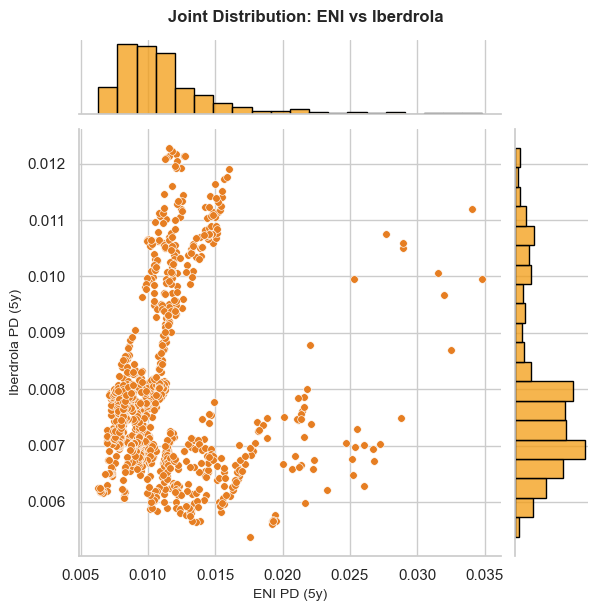

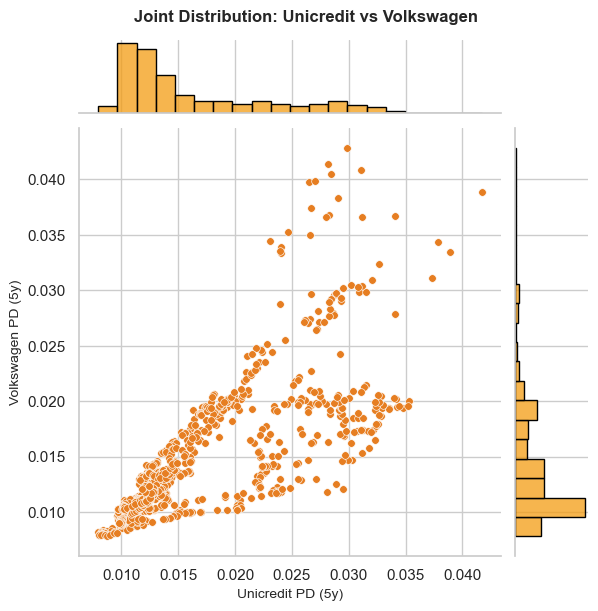

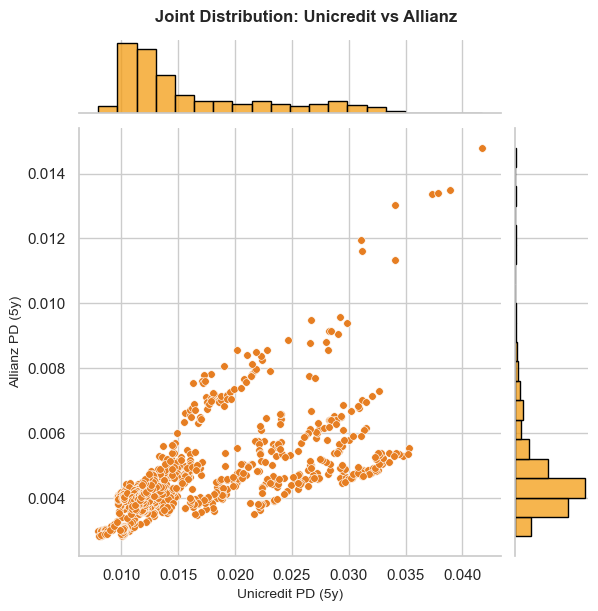

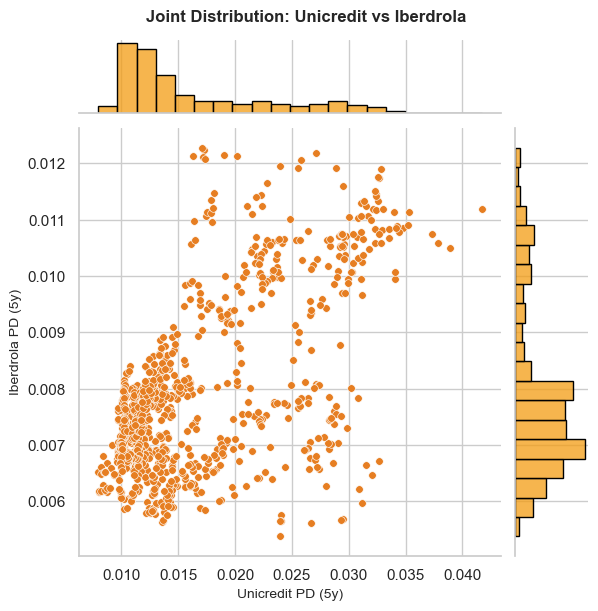

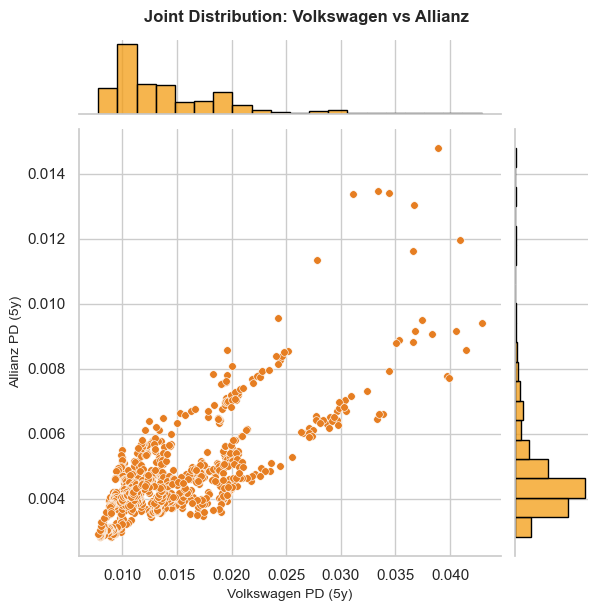

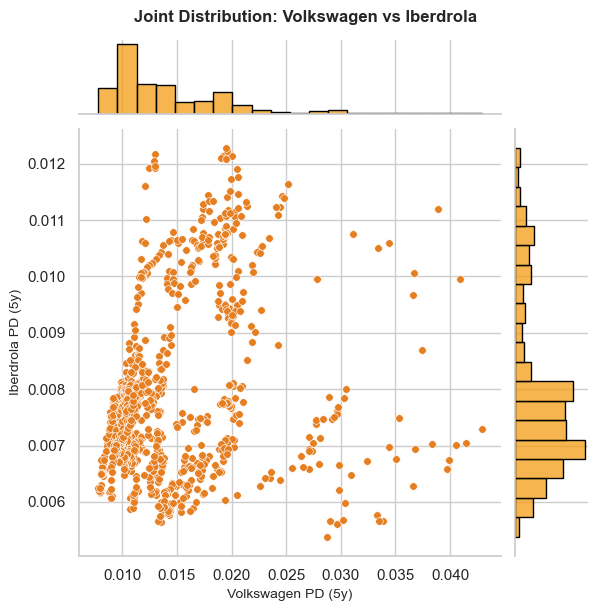

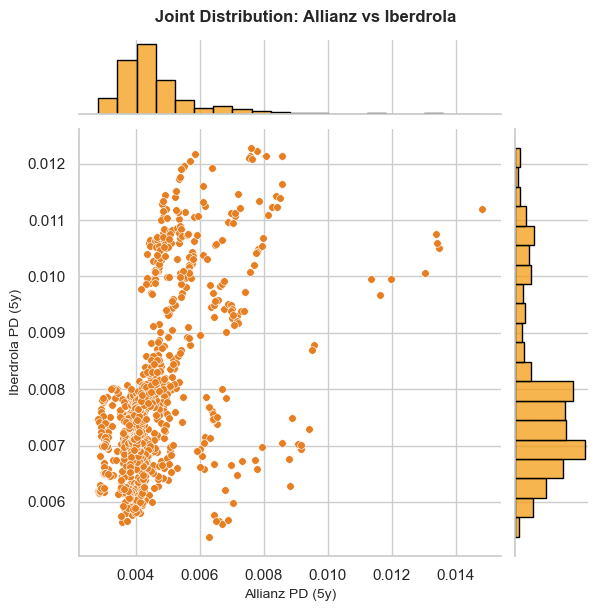

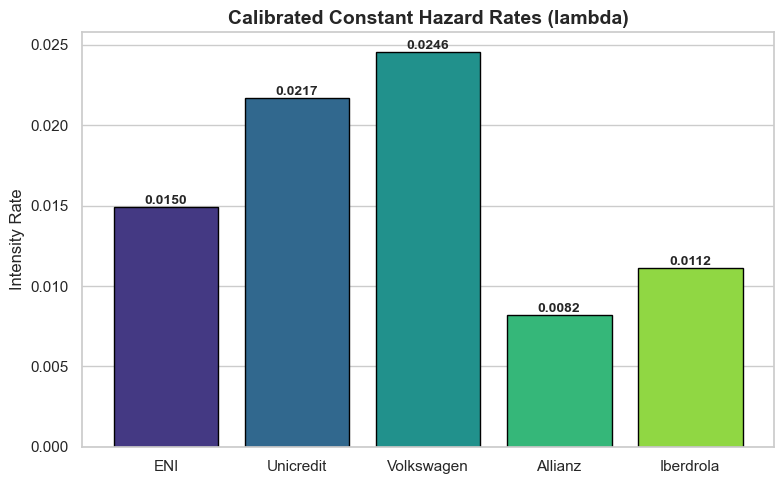

C:\Users\marco\AppData\Local\Temp\ipykernel_28224\3182227059.py:253: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


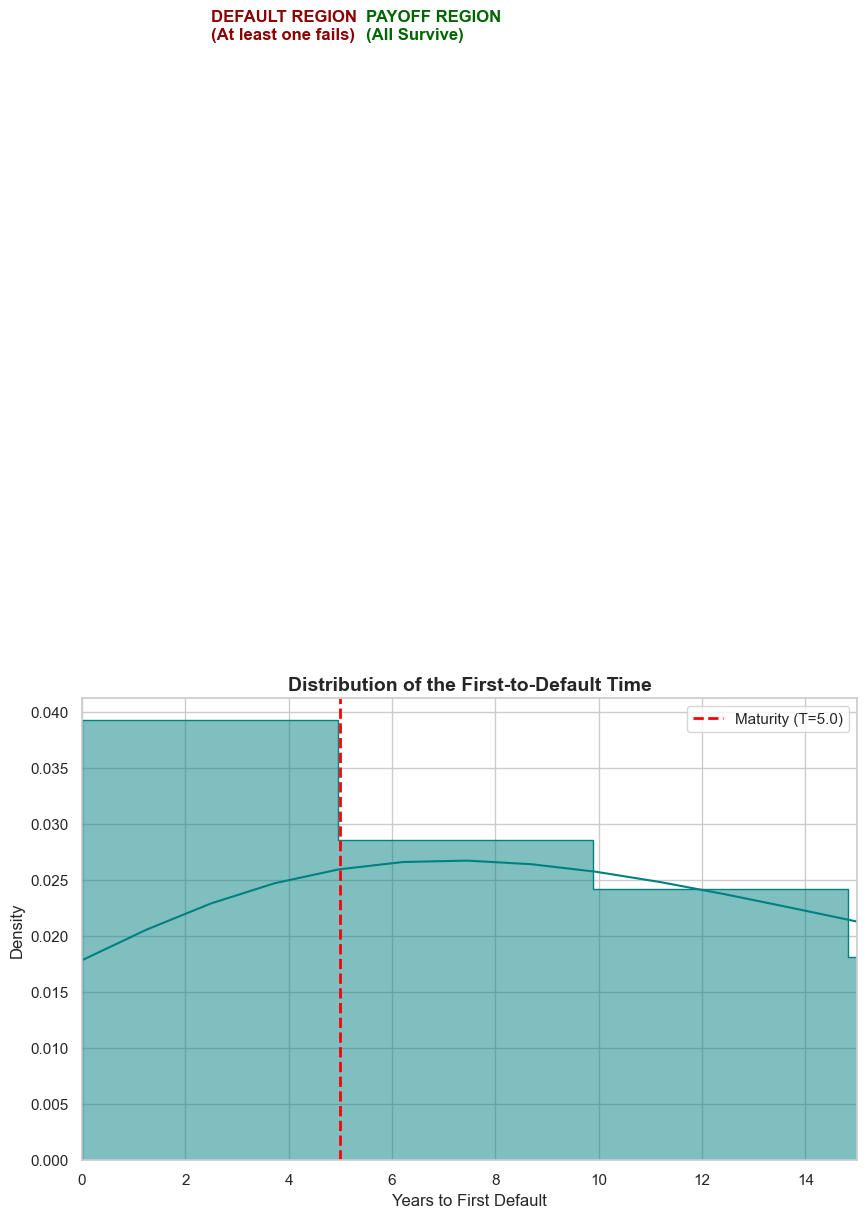

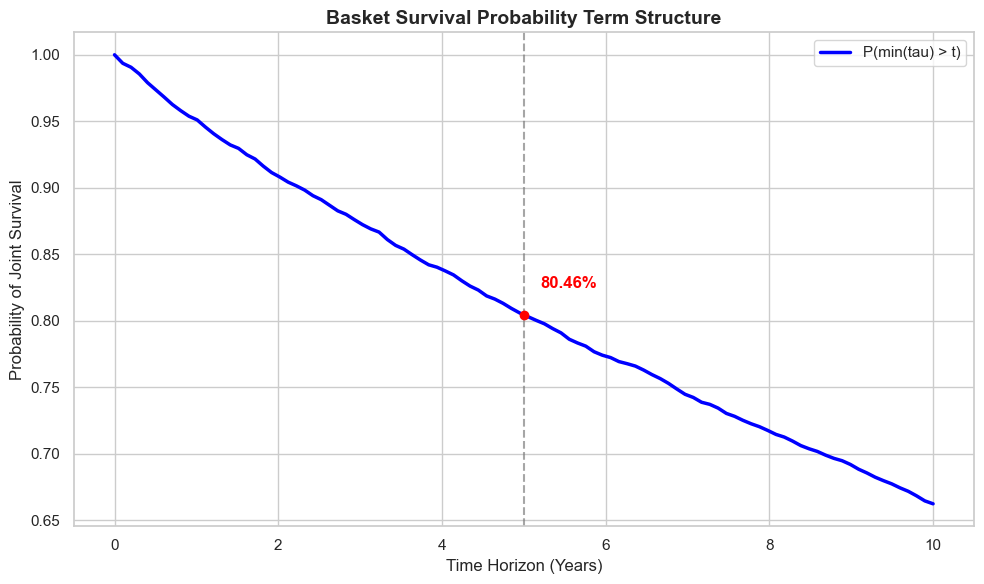

Generating Monte Carlo Diagnostics...


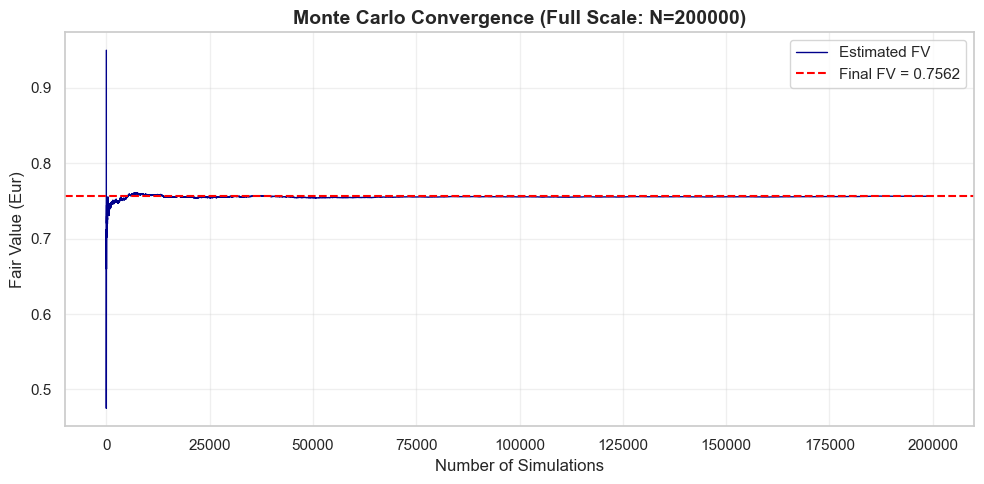

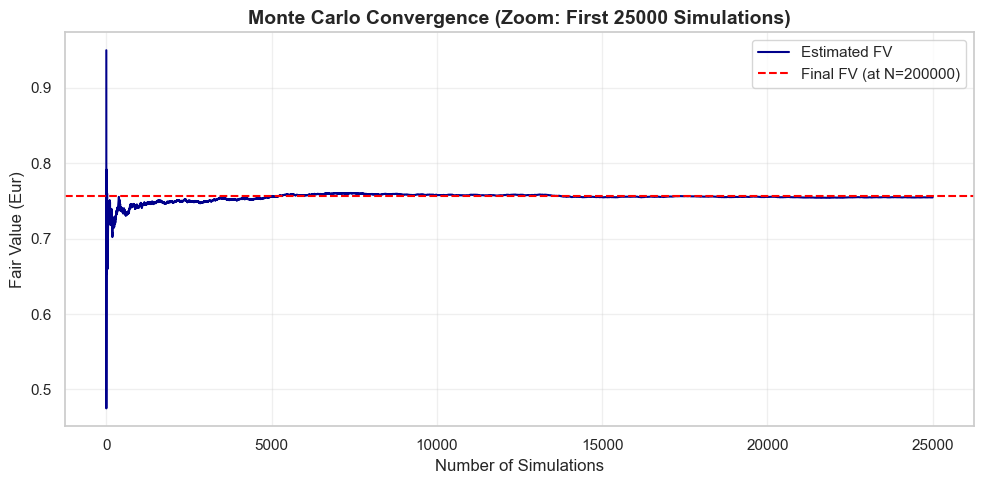

C:\Users\marco\AppData\Local\Temp\ipykernel_28224\3182227059.py:330: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=default_counts, palette="viridis", edgecolor="black")


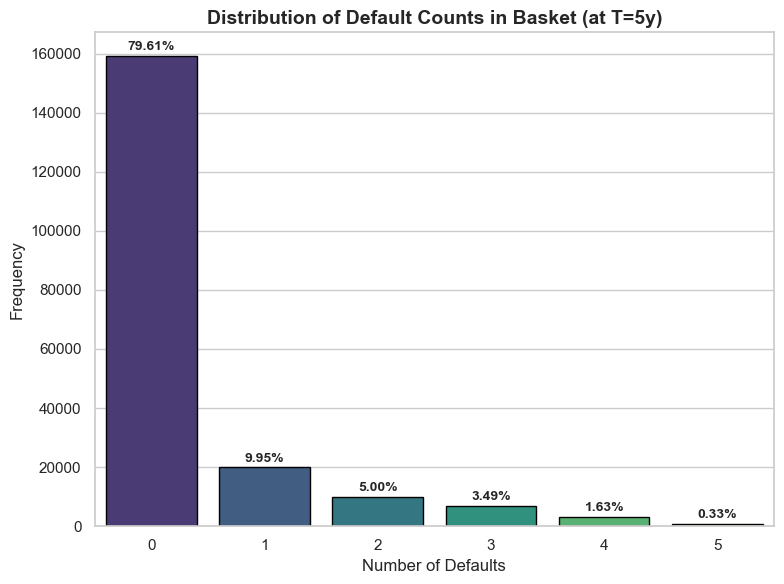

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import norm, rankdata
from itertools import combinations

# ============================================================
# 1. CONFIGURATION & SETTINGS
# ============================================================

FILE_TS   = Path("CDS_time_series.xlsx")
SHEET_TS  = "Sheet1"

# The basket of entities we are modeling
NAMES = ["ENI", "Unicredit", "Volkswagen", "Allianz", "Iberdrola"]

# Financial Assumptions
RECOVERY = 0.40
LGD      = 1.0 - RECOVERY
T        = 5.0   # Maturity of the contract (Years)
P_0_5    = 0.95  # Risk-free Discount Factor for 5Y (Zero Coupon Bond Price)

# Monte Carlo Settings
N_MC     = 200_000
RNG_SEED = 42

# Styling for charts
sns.set_theme(style="whitegrid")

# ============================================================
# 2. DATA PROCESSING & MODELING FUNCTIONS
# ============================================================

def load_cds_time_series(file_path: Path, sheet_name: str, names: list[str]) -> pd.DataFrame:
    """
    Loads historical CDS spreads (in basis points) from Excel.
    Expects a specific format with headers on row 3 (index 2).
    """
    if not file_path.exists():
        print(f"WARNING: File {file_path} not found. Returning empty DataFrame.")
        return pd.DataFrame()
        
    raw = pd.read_excel(file_path, sheet_name=sheet_name, header=2)
    
    # Check if all required columns exist
    missing = [nm for nm in names if nm not in raw.columns]
    if missing:
        raise ValueError(f"Missing columns in data: {missing}")
    
    # Clean data: Select columns, ensure floats, drop missing rows
    df = raw[names].copy().astype(float).dropna(how="any")
    return df

def cds_bps_to_default_prob_5y(cds_bps_df: pd.DataFrame, recovery: float = RECOVERY) -> pd.DataFrame:
    """
    Bootstrap approximation: Converts CDS spreads (bps) to 5Y Default Probabilities.
    Formula: P_def = 1 - exp(-Spread / (1-R))
    """
    cds_decimal = cds_bps_df / 10_000.0
    p = 1.0 - np.exp(-cds_decimal / (1.0 - recovery))
    return p

def to_pseudo_uniforms(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms marginal distributions to Uniform(0,1) using the Empirical CDF (Rank Transform).
    This is the first step in Copula calibration (Canonical Maximum Likelihood).
    """
    n = len(df)
    U = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)
    
    for col in df.columns:
        # rankdata returns 1..N. We divide by N+1 to keep range in (0,1)
        ranks = rankdata(df[col].values, method="average")
        U[col] = ranks / (n + 1.0)
    return U

def fit_gaussian_copula(U: pd.DataFrame):
    """
    Calibrates a Gaussian Copula by:
    1. Mapping Uniforms -> Standard Normals (Inverse Normal CDF)
    2. Computing the Pearson Correlation of these Normals
    """
    # Clip to avoid infinity at 0 or 1
    eps = 1e-10
    U_clipped = U.clip(eps, 1.0 - eps)
    
    # Inverse probability transform
    Z = pd.DataFrame(norm.ppf(U_clipped), columns=U.columns, index=U.index)
    
    # Correlation matrix
    C = Z.corr()
    return C, Z

def check_and_fix_corr_posdef(C: pd.DataFrame, tol: float = 1e-10) -> pd.DataFrame:
    """
    Ensures the correlation matrix is Positive Definite (PD).
    If not, it applies a small diagonal shift (spectral regularization).
    Necessary because Cholesky decomposition fails on non-PD matrices.
    """
    vals, vecs = np.linalg.eigh(C.values)
    min_eig = vals.min()
    print(f"\nMinimum eigenvalue of Correlation Matrix: {min_eig:.6e}")

    if min_eig >= tol:
        print("Matrix is Positive Definite. Proceeding.\n")
        return C

    # If slightly negative (numerical noise), shift eigenvalues
    if min_eig > -1e-3:
        shift = -min_eig + tol
        print(f"Fixing non-PD matrix: Applying diagonal shift of {shift:.6e}\n")
        C_adj = C.values + shift * np.eye(C.shape[0])
        return pd.DataFrame(C_adj, index=C.index, columns=C.columns)

    raise RuntimeError("Correlation matrix is strongly non-PD (broken data).")

def calibrate_constant_hazards_from_last_spread(cds_bps_df: pd.DataFrame, recovery: float = RECOVERY) -> pd.Series:
    """
    Calibrates the current hazard rates (lambdas) from the most recent CDS spread.
    lambda = Spread / (1 - Recovery)
    """
    last_spreads_bps = cds_bps_df.iloc[-1]
    cds_decimal_last = last_spreads_bps / 10_000.0
    lambdas = cds_decimal_last / (1.0 - recovery)
    return lambdas

def simulate_basket_no_default_FV(lambdas: pd.Series, C: pd.DataFrame, T: float = T, P_0_T: float = P_0_5, n_paths: int = N_MC, seed: int | None = RNG_SEED):
    """
    Runs the Monte Carlo simulation to price the "First-to-Default" basket.
    Returns: Probability of survival, Fair Value, and Standard Errors.
    """
    if seed is not None:
        np.random.seed(seed)

    names = list(lambdas.index)
    dim = len(names)
    
    # Cholesky Decomposition for correlated random numbers
    C_np = C.loc[names, names].values
    L = np.linalg.cholesky(C_np)

    # 1. Generate Correlated Standard Normals
    Z_sim = np.random.normal(size=(n_paths, dim))
    X = Z_sim @ L.T
    
    # 2. Convert to Uniforms (Copula samples)
    U_sim = norm.cdf(X)

    # 3. Determine Survival
    # Default occurs if U_sim < 1 - exp(-lambda * T)
    # Equivalently, Survival check: -ln(1 - U) > lambda * T
    lambda_arr = lambdas.values.reshape(1, -1)
    thresh = -np.log(1.0 - U_sim)
    lhs = lambda_arr * T

    surv_individual = thresh > lhs
    
    # Basket survives only if ALL individual names survive
    surv_all = np.all(surv_individual, axis=1).astype(float)

    # 4. Statistics
    prob_all_survive = surv_all.mean()
    se_prob = np.sqrt(prob_all_survive * (1.0 - prob_all_survive) / n_paths)

    FV = P_0_T * prob_all_survive
    se_FV = P_0_T * se_prob

    return prob_all_survive, FV, se_prob, se_FV

# ============================================================
# 3. VISUALIZATION FUNCTIONS
# ============================================================

def visualize_all_results(cds_bps, p_5y, U, C, lambdas):
    """
    Plots the Correlation Matrix, Joint Distributions (Scatter), and Hazard Rates.
    """
    # A. Correlation Matrix Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(C, annot=True, fmt=".2f", cmap="RdBu_r", vmin=-1, vmax=1, linewidths=.5)
    plt.title("Calibrated Gaussian Copula Correlation Matrix", fontsize=14, fontweight='bold')
    plt.yticks(rotation=0) 
    plt.tight_layout()
    plt.show()

    # B. Pairwise Scatter Plots (Visualizing Dependence)
    print("Generating Pairwise Joint Plots...")
    pairs = list(combinations(p_5y.columns, 2))
    
    for name_x, name_y in pairs:
        g = sns.jointplot(
            data=p_5y, 
            x=name_x, 
            y=name_y,
            kind="scatter",            
            color="#e67e22",
            edgecolor="white",        
            s=30,                     
            height=6,
            marginal_kws=dict(bins=20, fill=True, color="#f39c12", edgecolor="black")
        )
        g.fig.suptitle(f"Joint Distribution: {name_x} vs {name_y}", y=1.02, fontsize=12, fontweight='bold')
        g.set_axis_labels(f"{name_x} PD (5y)", f"{name_y} PD (5y)", fontsize=10)
        plt.show()

    # C. Hazard Rates Bar Chart
    plt.figure(figsize=(8, 5))
    colors = sns.color_palette("viridis", len(lambdas))
    bars = plt.bar(lambdas.index, lambdas.values, color=colors, edgecolor='black')
    plt.title("Calibrated Constant Hazard Rates (lambda)", fontsize=14, fontweight='bold')
    plt.ylabel("Intensity Rate")
    plt.grid(axis='x')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

def visualize_simulation_insights(lambdas, C, T, n_paths=5000):
    """
    Runs a small sub-simulation to plot the "First-to-Default" time distribution.
    """
    names = list(lambdas.index)
    
    # Re-simulate specifically for plotting
    C_np = C.loc[names, names].values
    L = np.linalg.cholesky(C_np)
    Z_sim = np.random.normal(size=(n_paths, len(names)))
    X = Z_sim @ L.T
    U_sim = norm.cdf(X)
    
    # Convert Uniforms to Default Times: tau = -ln(1-U)/lambda
    default_times = -np.log(1.0 - U_sim) / lambdas.values.reshape(1, -1)
    df_tau = pd.DataFrame(default_times, columns=names)

    # A. First-to-Default Distribution
    min_tau = df_tau.min(axis=1)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(min_tau, bins=50, kde=True, color="teal", stat="density", element="step")
    plt.axvline(T, color='red', linewidth=2, linestyle='--', label=f'Maturity (T={T})')
    plt.text(T + 0.5, 0.1, "PAYOFF REGION\n(All Survive)", color='darkgreen', fontweight='bold')
    plt.text(T - 2.5, 0.1, "DEFAULT REGION\n(At least one fails)", color='darkred', fontweight='bold')
    plt.title("Distribution of the First-to-Default Time", fontsize=14, fontweight='bold')
    plt.xlabel("Years to First Default")
    plt.ylabel("Density")
    plt.xlim(0, 15)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # B. Survival Probability Curve
    time_grid = np.linspace(0, 10, 100)
    surv_probs = [(min_tau > t).mean() for t in time_grid]
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_grid, surv_probs, color='blue', linewidth=2.5, label="P(min(tau) > t)")
    
    # Highlight the 5Y point
    p_5 = (min_tau > T).mean()
    plt.scatter([T], [p_5], color='red', zorder=5)
    plt.text(T+0.2, p_5+0.02, f"{p_5:.2%}", color='red', fontweight='bold')
    plt.axvline(T, color='gray', linestyle='--', alpha=0.7)
    
    plt.title("Basket Survival Probability Term Structure", fontsize=14, fontweight='bold')
    plt.xlabel("Time Horizon (Years)")
    plt.ylabel("Probability of Joint Survival")
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_monte_carlo_diagnostics(lambdas, C, T, P_0_5, n_paths=200000):
    """
    Generates convergence plots to check stability of the Monte Carlo estimator.
    """
    print("Generating Monte Carlo Diagnostics...")
    
    names = list(lambdas.index)
    C_np = C.loc[names, names].values
    L = np.linalg.cholesky(C_np)
    
    Z_sim = np.random.normal(size=(n_paths, len(names)))
    X = Z_sim @ L.T
    U_sim = norm.cdf(X)
    
    # Survival Thresholds
    thresholds = 1.0 - np.exp(-lambdas.values.reshape(1, -1) * T)
    defaults_matrix = U_sim <= thresholds
    
    # --- Convergence Calculation ---
    survived_all = (defaults_matrix.sum(axis=1) == 0).astype(float)
    
    # Cumulative mean calculation
    cumulative_means = np.cumsum(survived_all) / (np.arange(n_paths) + 1)
    cumulative_fv = cumulative_means * P_0_5
    final_val = cumulative_fv[-1]

    # Plot 1: Full Convergence
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_fv, color='darkblue', linewidth=1.0, label='Estimated FV')
    plt.axhline(final_val, color='red', linestyle='--', label=f'Final FV = {final_val:.4f}')
    plt.title(f"Monte Carlo Convergence (Full Scale: N={n_paths})", fontsize=14, fontweight='bold')
    plt.xlabel("Number of Simulations")
    plt.ylabel("Fair Value (Eur)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 2: Zoomed Convergence (First 25k)
    zoom_n = 25000
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_fv[:zoom_n], color='darkblue', linewidth=1.5, label='Estimated FV')
    plt.axhline(final_val, color='red', linestyle='--', label=f'Final FV (at N={n_paths})')
    plt.title(f"Monte Carlo Convergence (Zoom: First {zoom_n} Simulations)", fontsize=14, fontweight='bold')
    plt.xlabel("Number of Simulations")
    plt.ylabel("Fair Value (Eur)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Histogram of Default Counts
    default_counts = defaults_matrix.sum(axis=1)
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x=default_counts, palette="viridis", edgecolor="black")
    plt.title("Distribution of Default Counts in Basket (at T=5y)", fontsize=14, fontweight='bold')
    plt.xlabel("Number of Defaults")
    plt.ylabel("Frequency")
    
    total = len(default_counts)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width()/2., height + (total*0.01),
                    '{:1.2f}%'.format(100 * height/total), ha="center", fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ============================================================
# 4. MAIN EXECUTION FLOW
# ============================================================

# 1. Load Data
cds_bps = load_cds_time_series(FILE_TS, SHEET_TS, NAMES)

if not cds_bps.empty:
    print("Loaded CDS time series head:\n", cds_bps.head(), "\n")

    # 2. Transform Spreads to Default Probabilities
    p_5y = cds_bps_to_default_prob_5y(cds_bps)
    print("5y default probabilities head:\n", p_5y.head(), "\n")

    # 3. Fit Gaussian Copula
    # Convert marginals to Uniforms
    U = to_pseudo_uniforms(p_5y)
    
    # Get Correlation Matrix
    C_raw, Z = fit_gaussian_copula(U)
    print("Raw Gaussian Copula Correlation Matrix:\n", C_raw, "\n")
    
    # Ensure Matrix is Positive Definite
    C = check_and_fix_corr_posdef(C_raw)

    # 4. Calibrate Marginal Hazard Rates
    # We use the most recent spread to define the current risk level
    lambdas = calibrate_constant_hazards_from_last_spread(cds_bps)
    print("Constant hazard rates (lambda):\n", lambdas, "\n")

    # 5. Run Monte Carlo Simulation
    
    prob_all_survive, FV, se_prob, se_FV = simulate_basket_no_default_FV(lambdas, C, T, P_0_5, N_MC)

    # 6. Print Results
    print("-" * 40)
    print(f"MONTE CARLO RESULTS (N={N_MC})")
    print("-" * 40)
    print(f"Prob(All Survive 5y) : {prob_all_survive:.6f} (SE={se_prob:.6f})")
    print(f"Fair Value (FV)      : {FV:.6f} (SE={se_FV:.6f})")
    print("-" * 40)

    # 7. Generate Visualizations
    print("\nGenerating Visualizations...")
    
    # Standard plots
    visualize_all_results(cds_bps, p_5y, U, C, lambdas)
    
    # Simulation insights (First-to-Default distributions)
    visualize_simulation_insights(lambdas, C, T)
    
    # Convergence Diagnostics (Now correctly defined before use)
    visualize_monte_carlo_diagnostics(lambdas, C, T, P_0_5, N_MC)

else:
    print("Skipping execution due to missing data file.")